# ENSAE Master Spécialisé Data Science - Projet Python de 1er semestre

*Par Alexandre Combessie et Thibaut Duguet*

## Chargement des données

Les données complètes sont disponibles sur le site http://jmcauley.ucsd.edu/data/amazon/links.html. Pour commencer, on se concentre sur des bases de données pour des catégories spécifiques de produit, afin d'avoir une taille raisonnable.
Une fois sur la page, il faut télécharger les reviews pour les catégories "Musical Instruments" et "Baby". Nous avons également travaillé sur les reviews de la catégorie "Movies and TV", mais la taille du fichier et les temps de calcul rendent son utilisation beaucoup moins aisée.

In [3]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import statistics as stat
from io import StringIO
import nltk
import sklearn

Tout d'abord, on sélectionne la catégorie de produit à étudier:

In [4]:
category_options={
    "Musical Instruments": "reviews_Musical_Instruments.json.gz",
    "Baby": "reviews_Baby.json.gz",
    "Movies and TV": "reviews_Movies_and_TV.json.gz",
}
dropdown = widgets.Dropdown(options=category_options, description="Catégorie de produit à étudier")
display(dropdown)

Ensuite, on décompresse le fichier pour obtenir un fichier en format json

In [5]:
if(not(os.path.isfile(dropdown.value[:-3]))):
    inputFile = gzip.open(dropdown.value, 'rb')
    outputFile = open(dropdown.value[:-3], 'wb')
    outputFile.write(inputFile.read())
    inputFile.close()
    outputFile.close()

On la transforme en Pandas DataFrame 

In [6]:
data=[]
filepath=dropdown.value[:-3]
with open(filepath) as f:
    for line in f:
        data.append(json.loads(line))
df=pd.DataFrame(data)

In [114]:
df=pd.DataFrame(data1)

In [ ]:
df.to_csv("Movies and TV.csv", sep='\t')

In [3]:
df=pd.read_csv("Movies and TV.csv", sep='\t')

In [115]:
print(df.shape)
df.head()

(915448, 9)


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0188399313,"[0, 0]",5,"They work very well. Easy to clean, we wash th...","05 27, 2013",A28O3NP6WR5517,Jennifer gymer,These bottles are great!,1369612800
1,0188399399,"[1, 1]",5,it came early and was not disappointed. i love...,"04 9, 2013",AX0M1Z6ZWO52J,Ash M.,perfect,1365465600
2,0188399518,"[0, 0]",4,I ended up with a variety of different brands ...,"02 14, 2014",A1KD7N84L7NIUT,Buffy Fan,Good cotton wipes,1392336000
3,0188399518,"[1, 1]",3,"These flannel wipes are OK, but in my opinion ...","07 8, 2013",A29CUDEIF4X1UO,J. D. Solbach,Sending them back.,1373241600
4,0316967297,"[0, 0]",4,"Cute quilt, the colors are perfect and my litt...","09 6, 2013",A32592TYN6C9EM,Amazon Customer,Very cute,1378425600


## Séparation Training and Validation sets

Avant de commencer toute analyse ou modélisation, il faut séparer l'échantillon d'entrainement et l'échantillon de validation. On procède comme suit:

In [116]:
from sklearn.cross_validation import train_test_split
y = df["overall"]
X = df.drop("overall",axis=1,inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)
df_train=pd.concat([X,y],axis=1).iloc[X_train] # return dataframe train
df_test=pd.concat([X,y],axis=1).iloc[X_test] # return dataframe test
print(df_train.shape, df_test.shape)

(732358, 9) (183090, 9)


In [117]:
del df

In [118]:
del X, y

In [119]:
del X_train, X_test

## Analyse descriptive

Regardons la structure de la table:

In [120]:
df_train.head()

,asin,helpful,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,overall
446247,B002RXM9M0,"[0, 0]",I am very happy with the dreambaby toy chain. ...,"02 2, 2014",A32JCNFALAFPME,TaLona Brooks,dreambaby toy chain,1391299200,5
693612,B005G3QSF2,"[0, 0]","We had twins in March, so we actually go two o...","05 20, 2014",A3CSPK6HLMNTAT,Paul Townsend,Work fine when they work right,1400544000,3
338612,B001GQ2RW6,"[0, 1]",Not all kids Potty train early therefore they ...,"10 14, 2013",A25OV5MGGUX64Y,NAZLY LEON,Potty Seat is too small as most are.,1381708800,1
452357,B002TMSXF6,"[0, 0]",I wish this worked but it doesn't. Just doesn'...,"11 5, 2013",A1SJLHSU5SLBM0,Maine Shopper,Doesn't stick,1383609600,1
94538,B0007KMUH4,"[0, 0]",This was very nice as our little guy got older...,"03 11, 2013",AYE83D52EMFZT,Ginger Wik,Loved it!,1362960000,5


In [121]:
del df_train["reviewerName"], df_test["reviewerName"]

Etudions les dimensions clés de la table:

In [122]:
Nbreviews=len(df_train)
Nbproducts=len(set(df_train["asin"]))
Nbreviewers=len(set(df_train["reviewerID"]))
print("Le nombre total de reviews est: "+str(Nbreviews))
print("Le nombre total de produits est: "+str(Nbproducts))
print("Le nombre total de reviewers est: "+str(Nbreviewers))
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbproducts,1))+ " reviews par produit")
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbreviewers,1))+ " reviews par reviewers")

Le nombre total de reviews est: 732358
Le nombre total de produits est: 59373
Le nombre total de reviewers est: 451872
Soit un nombre moyen de 12.3 reviews par produit
Soit un nombre moyen de 1.6 reviews par reviewers


Analysons la distribution des notes des reviews

count    732358.00
mean          4.12
std           1.29
min           1.00
25%           4.00
50%           5.00
75%           5.00
max           5.00
Name: overall, dtype: float64


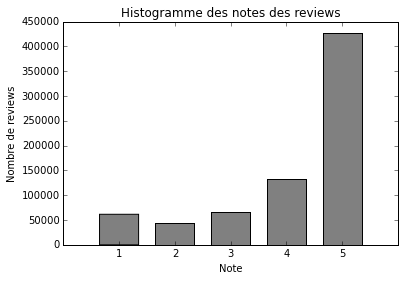

In [123]:
print(df_train["overall"].describe().round(2))
%matplotlib inline 
a=[int(i) for i in df_train["overall"]]
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes des reviews");
plt.xlabel("Note");
plt.ylabel("Nombre de reviews");

Regardons la distribution des notes moyennes par produit. On constate que la distribution est moins "skewed" que précedemment.

count    59373.00
mean         4.06
std          1.04
min          1.00
25%          3.57
50%          4.33
75%          5.00
max          5.00
Name: overall, dtype: float64


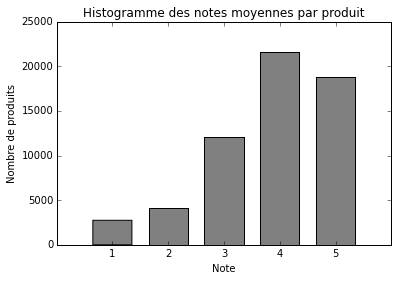

In [124]:
average_note_byproduct=df_train[["asin","overall"]].groupby("asin", as_index=False).mean()
print(average_note_byproduct["overall"].describe().round(2))
%matplotlib inline 
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(average_note_byproduct["overall"], bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes moyennes par produit");
plt.xlabel("Note");
plt.ylabel("Nombre de produits");

Regardons la distribution du nombre de reviews par utilisateur.

count    451872.00
mean          1.62
std           1.85
min           1.00
25%           1.00
50%           1.00
75%           2.00
max         130.00
dtype: float64


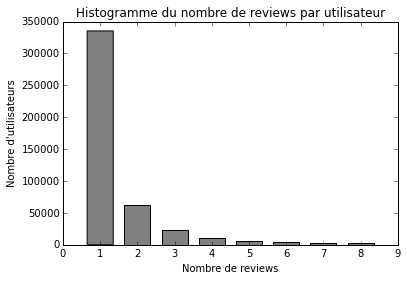

In [125]:
import collections
Nbreview_by_user=collections.Counter(df_train["reviewerID"])
print(pd.Series(Nbreview_by_user).describe().round(2))
bins=range(1,10,1)
a = np.clip(list(Nbreview_by_user.values()), 1, 10)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de reviews par utilisateur");
plt.xlabel("Nombre de reviews");
plt.ylabel("Nombre d'utilisateurs");

Définissons la fonction de comptage du nombre de mots d'une review et appliquons la à nos données

In [14]:
def countWords(review):
    return(len(review.split()))

In [126]:
df_train["countWordsReview"] = df_train["reviewText"].astype(str).apply(countWords)
df_test["countWordsReview"] = df_test["reviewText"].astype(str).apply(countWords)
df_train["countWordsSummary"] = df_train["summary"].astype(str).apply(countWords)
df_test["countWordsSummary"] = df_test["summary"].astype(str).apply(countWords)

Regardons la distribution du nombre de mots des reviews

In [16]:
print(df_train["countWordsReview"].describe().round(2))

count    400146.00
mean         87.85
std         118.40
min           0.00
25%          28.00
50%          49.00
75%          99.00
max        5291.00
Name: countWordsReview, dtype: float64


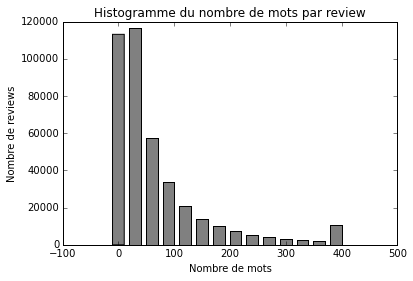

In [17]:
%matplotlib inline 
bins=range(0,430,30)
a = list(np.clip(df_train["countWordsReview"], 0, 400))
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

Maintenant regardons plus spécifiquement entre 0 et 100 mots

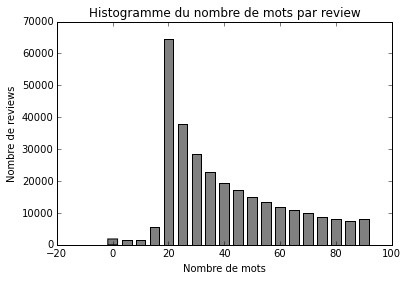

In [18]:
a = [s for s in df_train["countWordsReview"] if s < 101]
%matplotlib inline 
bins=range(0,100,5)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

## Préparation des données

On prépare les données de texte en utilisant la fonction `TfidfVectorizer` du package `sklearn`. Notons que nous utilisons les stopwords fournis par `nltk` pour réduire le nombre de mots.

In [127]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
tfidf_vect = TfidfVectorizer()
tfidf_vect_stopword = TfidfVectorizer(stop_words= stopwords.words('english'), min_df=0.0005)

### 1. Texte complet de la review

#### a. Echantillon Train

In [128]:
corpus_train_reviewText=list(df_train["reviewText"].astype(str))
X_train_tfidf_reviewText = tfidf_vect_stopword.fit_transform(corpus_train_reviewText)
X_train_tfidf_reviewText.shape

(732358, 4990)

In [23]:
del df_train["reviewText"]

#### b. Echantillon Test

In [129]:
corpus_test_reviewText=list(df_test["reviewText"].astype(str))
X_test_tfidf_reviewText = tfidf_vect_stopword.transform(corpus_test_reviewText)
X_test_tfidf_reviewText.shape

(183090, 4990)

In [25]:
del df_test["reviewText"]

### 2. Texte du résumé de la review

#### a. Echantillon Train

In [130]:
corpus_train_summary=list(df_train["summary"].astype(str))
X_train_tfidf_summary = tfidf_vect_stopword.fit_transform(corpus_train_summary)
X_train_tfidf_summary.shape

(732358, 731)

In [27]:
del df_train["summary"]

#### b. Echantillon Test

In [131]:
corpus_test_summary=list(df_test["summary"].astype(str))
X_test_tfidf_summary = tfidf_vect_stopword.transform(corpus_test_summary)
X_test_tfidf_summary.shape

(183090, 731)

In [29]:
del df_test["summary"]

### 3. Features supplémentaires

Nous allons créer des variables pour le mois et le jour de la review, ce qui peut influencer la note.

In [132]:
from datetime import datetime
df_train["Weekday"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_test["Weekday"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_train["Weekday"].head()

446247    Sun
693612    Tue
338612    Mon
452357    Tue
94538     Mon
Name: Weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

In [133]:
df_train["Month"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_test["Month"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_train["Month"].head()

446247    02
693612    05
338612    10
452357    11
94538     03
Name: Month, dtype: category
Categories (12, object): [01, 02, 03, 04, ..., 09, 10, 11, 12]

In [134]:
from sklearn.feature_extraction import DictVectorizer
dic_vec = DictVectorizer()

#### a. Echantillon Train

In [135]:
from sklearn.preprocessing import normalize
X_train_countWords=normalize(df_train[["countWordsReview","countWordsSummary"]].astype(float),axis=0)
print(X_train_countWords.shape)

(732358, 2)


In [137]:
dic_train_weekdays = pd.DataFrame(df_train["Weekday"]).to_dict('records')
X_train_weekdays = dic_vec.fit_transform(dic_train_weekdays)
X_train_weekdays.shape

(732358, 7)

In [138]:
dic_train_months = pd.DataFrame(df_train["Month"]).to_dict('records')
X_train_months = dic_vec.fit_transform(dic_train_months)
X_train_months.shape

(732358, 12)

#### b. Echantillon Test

In [139]:
from sklearn.preprocessing import normalize
X_test_countWords=normalize(df_test[["countWordsReview","countWordsSummary"]].astype(float),axis=0)
print(X_test_countWords.shape)

(183090, 2)


In [140]:
dic_test_weekdays = pd.DataFrame(df_test["Weekday"]).to_dict('records')
X_test_weekdays = dic_vec.fit_transform(dic_test_weekdays)
X_test_weekdays.shape

(183090, 7)

In [141]:
dic_test_months = pd.DataFrame(df_test["Month"]).to_dict('records')
X_test_months = dic_vec.fit_transform(dic_test_months)
X_test_months.shape

(183090, 12)

In [39]:
del df_train["unixReviewTime"], df_test["unixReviewTime"], df_train["Month"], df_test["Month"], df_train["Weekday"], df_test["Weekday"]

In [40]:
del df_train["reviewTime"], df_test["reviewTime"], df_train["helpful"], df_test["helpful"]

### 4. Combinaison de toutes les features

#### a. Echantillon Train

In [142]:
from scipy.sparse import hstack
X_train_alltext=hstack([X_train_tfidf_reviewText, X_train_tfidf_summary])
print(X_train_alltext.shape)

(732358, 5721)


In [143]:
X_train_allfeatures = hstack([X_train_alltext,X_train_countWords, X_train_weekdays, X_train_months])
print(X_train_allfeatures.shape)

(732358, 5742)


In [144]:
X_train_supfeatures = hstack([X_train_countWords, X_train_weekdays, X_train_months])
print(X_train_supfeatures.shape)

(732358, 21)


#### b. Echantillon Test

In [145]:
X_test_alltext=hstack([X_test_tfidf_reviewText, X_test_tfidf_summary])
print(X_test_alltext.shape)

(183090, 5721)


In [146]:
X_test_allfeatures = hstack([X_test_alltext,X_test_countWords, X_test_weekdays, X_test_months])
print(X_test_allfeatures.shape)

(183090, 5742)


In [147]:
X_test_supfeatures = hstack([X_test_countWords, X_test_weekdays, X_test_months])
print(X_test_supfeatures.shape)

(183090, 21)


## Machine Learning

En utilisant la librairie `sklearn`, nous allons appliquer les modèles suivants:
- Naive Bayes avec modèle multinomial, 
- Support Vector Machines avec Stochastic Gradient Descent et fonction de perte logistique, 
 

Nous avons essayé des Random Forests mais les calculs n'ont jamais pu aboutir, compte tenu du grand nombre de dimensions. Nous avons choisi un modèle Multinomial pour le Naive Bayes car il est bien adapté aux données (matrice sparse de grande dimension). Un modèle Naive Bayes gaussian n'est pas compatible avec les matrices sparses, et un modèle Naive Bayes Bernoulli ne peut prendre que des variables booléennes en entrée. Quant au choix de la fonction de perte logistique pour le modèle Support Vector Machines, c'est la seule fonction qui permet de calculer des probabilités sur les valeurs prédites et donc de déterminer le critère AUC.

### 1. Texte complet de la review

In [39]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train.astype('category'))
predicted_NaiveBayes_reviewText = clf.predict(X_test_tfidf_reviewText)

In [40]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='log', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_tfidf_reviewText, y_train.astype('category'))
predicted_SVM_reviewText = clf2.predict(X_test_tfidf_reviewText)

### 2. Texte du résumé de la review

In [41]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf_summary, y_train.astype('category'))
predicted_NaiveBayes_summary = clf.predict(X_test_tfidf_summary)

In [42]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_tfidf_summary, y_train.astype('category'))
predicted_SVM_summary = clf2.predict(X_test_tfidf_summary)

### 3. Texte complet et résumé de la review

In [43]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_alltext, y_train.astype('category'))
predicted_NaiveBayes_alltext = clf.predict(X_test_alltext)

In [44]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_alltext, y_train.astype('category'))
predicted_SVM_alltext = clf2.predict(X_test_alltext)

### 4. Features supplémentaires

In [45]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_supfeatures, y_train.astype('category'))
predicted_NaiveBayes_supfeatures = clf.predict(X_test_supfeatures)

In [46]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_supfeatures, y_train.astype('category'))
predicted_SVM_supfeatures = clf2.predict(X_test_supfeatures)

### 5. Combinaison de toutes les features

In [47]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_allfeatures, y_train.astype('category'))
predicted_NaiveBayes_allfeatures = clf.predict(X_test_allfeatures)

In [48]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_allfeatures, y_train.astype('category'))
predicted_SVM_allfeatures = clf2.predict(X_test_allfeatures)

# Evaluation de la performance

### 1. Pour le texte complet de la review

In [49]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_reviewText == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_reviewText == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 65.0%
L'accuracy du classifieur SVM est de 62.0%


In [50]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_reviewText))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_reviewText))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.68      0.37      0.48      7140
        2.0       0.27      0.00      0.00      4540
        3.0       0.41      0.01      0.02      7761
        4.0       0.43      0.03      0.06     18551
        5.0       0.65      0.99      0.79     62045

avg / total       0.58      0.65      0.54    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      7140
        2.0       0.00      0.00      0.00      4540
        3.0       0.00      0.00      0.00      7761
        4.0       0.00      0.00      0.00     18551
        5.0       0.62      1.00      0.77     62045

avg / total       0.38      0.62      0.47    100037



/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_reviewText))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_reviewText))

Matrice de confusion du classifieur Naive Bayes 
 [[ 2633     9    28    74  4396]
 [  609     4    45   153  3729]
 [  355     2    68   389  6947]
 [  144     0    19   648 17740]
 [  147     0     7   255 61636]]
Matrice de confusion du classifieur SVM 
 [[    0     0     0     0  7140]
 [    0     0     0     0  4540]
 [    0     0     0     0  7761]
 [    0     0     0     0 18551]
 [    0     0     0     0 62045]]


### 2. Pour le résumé de la review

In [52]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_summary == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_summary == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 66.1%
L'accuracy du classifieur SVM est de 62.3%


In [53]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_summary))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_summary))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.59      0.37      0.46      7140
        2.0       0.41      0.03      0.06      4540
        3.0       0.52      0.13      0.21      7761
        4.0       0.48      0.06      0.11     18551
        5.0       0.67      0.99      0.80     62045

avg / total       0.61      0.66      0.57    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       1.00      0.00      0.00      7140
        2.0       0.00      0.00      0.00      4540
        3.0       0.66      0.03      0.06      7761
        4.0       0.41      0.04      0.07     18551
        5.0       0.63      0.99      0.77     62045

avg / total       0.59      0.62      0.49    100037



/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_summary))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_summary))

Matrice de confusion du classifieur Naive Bayes 
 [[ 2661    98   123   117  4141]
 [  805   150   318   132  3135]
 [  468    81  1040   528  5644]
 [  304    16   365  1132 16734]
 [  282    17   162   434 61150]]
Matrice de confusion du classifieur SVM 
 [[    7     0     4    67  7062]
 [    0     0    32    81  4427]
 [    0     0   253   195  7313]
 [    0     0    72   669 17810]
 [    0     0    23   628 61394]]


### 3. Texte complet et résumé de la review

In [55]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_alltext == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_alltext == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 69.3%
L'accuracy du classifieur SVM est de 63.1%


In [56]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_alltext))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_alltext))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.64      0.61      0.62      7140
        2.0       0.40      0.08      0.13      4540
        3.0       0.49      0.19      0.27      7761
        4.0       0.49      0.18      0.26     18551
        5.0       0.73      0.97      0.83     62045

avg / total       0.64      0.69      0.63    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.89      0.05      0.10      7140
        2.0       0.00      0.00      0.00      4540
        3.0       0.67      0.04      0.07      7761
        4.0       0.47      0.05      0.09     18551
        5.0       0.63      0.99      0.77     62045

avg / total       0.59      0.63      0.51    100037



/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_alltext))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_alltext))

Matrice de confusion du classifieur Naive Bayes 
 [[ 4320   240   204   181  2195]
 [ 1190   352   482   397  2119]
 [  625   207  1444  1343  4142]
 [  305    54   586  3347 14259]
 [  336    36   219  1546 59908]]
Matrice de confusion du classifieur SVM 
 [[  373     0     5    85  6677]
 [   31     0    44   117  4348]
 [    6     0   305   342  7108]
 [    1     0    83   878 17589]
 [    6     0    21   463 61555]]


### 4. Features supplémentaires

In [58]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_supfeatures == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_supfeatures == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 62.0%
L'accuracy du classifieur SVM est de 62.0%


In [59]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_supfeatures))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_supfeatures))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      7140
        2.0       0.00      0.00      0.00      4540
        3.0       0.00      0.00      0.00      7761
        4.0       0.00      0.00      0.00     18551
        5.0       0.62      1.00      0.77     62045

avg / total       0.38      0.62      0.47    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      7140
        2.0       0.00      0.00      0.00      4540
        3.0       0.00      0.00      0.00      7761
        4.0       0.00      0.00      0.00     18551
        5.0       0.62      1.00      0.77     62045

avg / total       0.38      0.62      0.47    100037



/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_supfeatures))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_supfeatures))

Matrice de confusion du classifieur Naive Bayes 
 [[    0     0     0     0  7140]
 [    0     0     0     0  4540]
 [    0     0     0     0  7761]
 [    0     0     0     0 18551]
 [    0     0     0     0 62045]]
Matrice de confusion du classifieur SVM 
 [[    0     0     0     0  7140]
 [    0     0     0     0  4540]
 [    0     0     0     0  7761]
 [    0     0     0     0 18551]
 [    0     0     0     0 62045]]


On constate qu'il s'agit d'un classifieur sans intérêt, car il ne prédit que des 5.

### 3. Pour la combinaison des features

In [61]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_allfeatures == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_allfeatures == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 69.3%
L'accuracy du classifieur SVM est de 63.2%


In [62]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_allfeatures))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_allfeatures))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.64      0.61      0.62      7140
        2.0       0.39      0.08      0.13      4540
        3.0       0.49      0.19      0.27      7761
        4.0       0.49      0.18      0.27     18551
        5.0       0.73      0.96      0.83     62045

avg / total       0.64      0.69      0.63    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.89      0.06      0.11      7140
        2.0       0.00      0.00      0.00      4540
        3.0       0.66      0.04      0.07      7761
        4.0       0.47      0.05      0.09     18551
        5.0       0.63      0.99      0.77     62045

avg / total       0.59      0.63      0.51    100037



/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_allfeatures))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_allfeatures))

Matrice de confusion du classifieur Naive Bayes 
 [[ 4332   235   204   184  2185]
 [ 1190   357   475   393  2125]
 [  615   214  1444  1365  4123]
 [  302    55   594  3385 14215]
 [  329    45   224  1622 59825]]
Matrice de confusion du classifieur SVM 
 [[  417     0     5    87  6631]
 [   35     0    47   119  4339]
 [    8     0   307   351  7095]
 [    1     0    83   906 17561]
 [    6     0    21   472 61546]]


## Simplification du problème en classification binaire

En étudiant les matrices de confusion obtenues, on voit qu'il est difficile de prédire distinctement les notes entre 1 et 4. Nous allons donc nous ramener à un sous-problème de classification binaire, c'est-à-dire de prédire si la note sera de 5 ou non.

In [64]:
def bin_transformation(x):
    if x==5:
        return("1")
    else:
        return("0")

In [148]:
y_train_bin=y_train.apply(bin_transformation).astype("category")
y_test_bin=y_test.apply(bin_transformation).astype("category")

On ré-entraîne tous les classifieurs pour ce problème binaire:

In [149]:
#Texte complet de la review
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train_bin)
predicted_bin_NaiveBayes_reviewText = clf.predict(X_test_tfidf_reviewText)
clf2 = SGDclass.fit(X_train_tfidf_reviewText, y_train_bin)
predicted_bin_SVM_reviewText = clf2.predict(X_test_tfidf_reviewText)
#Texte du résumé de la review
clf = MultinomialNB().fit(X_train_tfidf_summary, y_train_bin)
predicted_bin_NaiveBayes_summary = clf.predict(X_test_tfidf_summary)
clf2 = SGDclass.fit(X_train_tfidf_summary, y_train_bin)
predicted_bin_SVM_summary = clf2.predict(X_test_tfidf_summary)
#Texte complet et résumé de la review
clf = MultinomialNB().fit(X_train_alltext, y_train_bin)
predicted_bin_NaiveBayes_alltext = clf.predict(X_test_alltext)
clf2 = SGDclass.fit(X_train_alltext, y_train_bin)
predicted_bin_SVM_alltext = clf2.predict(X_test_alltext)
#Features supplémentaires
clf = MultinomialNB().fit(X_train_supfeatures, y_train_bin)
predicted_bin_NaiveBayes_supfeatures = clf.predict(X_test_supfeatures)
clf2 = SGDclass.fit(X_train_supfeatures, y_train_bin)
predicted_bin_SVM_supfeatures = clf2.predict(X_test_supfeatures)
#Combinaison de toutes les features
clf = MultinomialNB().fit(X_train_allfeatures, y_train_bin)
predicted_bin_NaiveBayes_allfeatures = clf.predict(X_test_allfeatures)
clf2 = SGDclass.fit(X_train_allfeatures, y_train_bin)
predicted_bin_SVM_allfeatures = clf.predict(X_test_allfeatures)

Maintenant on peut réévaluer l'ensemble des classifieurs sur nos features. Notons qu'on calcule les indicateurs Precision, Recall et f1-score pour le label "5" uniquement étant donné que le problème est binaire.

In [150]:
index_clf=["ReviewText-NaiveBayes","ReviewText-SVM","Summary-NaiveBayes","Summary-SVM",
           "Alltext-NaiveBayes","Alltext-SVM","Supfeatures-NaiveBayes","Supfeatures-SVM",
          "Allfeatures-NaiveBayes","Allfeatures-SVM"]
predicted_clf=[predicted_bin_SVM_reviewText, predicted_bin_SVM_reviewText, 
              predicted_bin_NaiveBayes_summary, predicted_bin_SVM_summary,
             predicted_bin_NaiveBayes_alltext, predicted_bin_SVM_alltext,
             predicted_bin_NaiveBayes_supfeatures, predicted_bin_SVM_supfeatures,
             predicted_bin_NaiveBayes_allfeatures, predicted_bin_SVM_allfeatures]
def percent_round1(x):
    return(str((x*100).round(1))+"%")
Accuracy_clf=[percent_round1(np.mean(x==y_test_bin)) for x in predicted_clf]
Report_clf=[sklearn.metrics.precision_recall_fscore_support(y_test_bin, x) for x in predicted_clf]
Precision_clf=[percent_round1(x[0][1]) for x in Report_clf]
Recall_clf=[percent_round1(x[1][1]) for x in Report_clf]
f1score_clf=[percent_round1(x[2][1]) for x in Report_clf]

dic_clf = {'Accuracy' : pd.Series(Accuracy_clf, index=index_clf),
     'Precision' : pd.Series(Precision_clf, index=index_clf),
     'Recall' : pd.Series(Recall_clf, index=index_clf),
     'f1-score': pd.Series(f1score_clf, index=index_clf),
    }
df_clf=pd.DataFrame(dic_clf)
df_clf

/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,f1-score
ReviewText-NaiveBayes,75.3%,72.1%,93.9%,81.6%
ReviewText-SVM,75.3%,72.1%,93.9%,81.6%
Summary-NaiveBayes,73.5%,72.7%,87.4%,79.3%
Summary-SVM,73.1%,71.8%,88.3%,79.2%
Alltext-NaiveBayes,80.7%,80.4%,88.3%,84.2%
Alltext-SVM,80.7%,79.9%,89.3%,84.3%
Supfeatures-NaiveBayes,58.1%,58.1%,100.0%,73.5%
Supfeatures-SVM,58.1%,58.1%,100.0%,73.5%
Allfeatures-NaiveBayes,80.6%,80.4%,88.2%,84.1%
Allfeatures-SVM,80.6%,80.4%,88.2%,84.1%


On voit que le classifieur le plus performant est le **Naive Bayes sur tout le texte**, sans les features supplémentaires. L'ajout des features supplémentaires n'augmente pas particulièrement la performance, sauf pour le modèle SVM, qui reste cependant en dessous du NaiveBayes. De manière générale, la performance des classifieurs SVM est inférieure ou égale à celle des classifieurs Naive Bayes.

Enfin, pour évaluer la performance, nous allons tracer la courbe de ROC et évaluer le critère AUC. Pour faciliter la lisibilité du graphique, on élimine le classifieur uniquement sur les variables supplémentaires, car celui-ci ne prédit que des 5.

In [155]:
#Texte complet de la review
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train_bin)
probas_bin_NaiveBayes_reviewText = clf.predict_proba(X_test_tfidf_reviewText)[:,1]
clf2 = SGDclass.fit(X_train_tfidf_reviewText, y_train_bin)
probas_bin_SVM_reviewText = clf2.predict_proba(X_test_tfidf_reviewText)[:,1]
#Texte du résumé de la review
clf = MultinomialNB().fit(X_train_tfidf_summary, y_train_bin)
probas_bin_NaiveBayes_summary = clf.predict_proba(X_test_tfidf_summary)[:,1]
clf2 = SGDclass.fit(X_train_tfidf_summary, y_train_bin)
probas_bin_SVM_summary = clf2.predict_proba(X_test_tfidf_summary)[:,1]
#Texte complet et résumé de la review
clf = MultinomialNB().fit(X_train_alltext, y_train_bin)
probas_bin_NaiveBayes_alltext = clf.predict_proba(X_test_alltext)[:,1]
clf2 = SGDclass.fit(X_train_alltext, y_train_bin)
probas_bin_SVM_alltext = clf2.predict_proba(X_test_alltext)[:,1]
#Combinaison de toutes les features
clf = MultinomialNB().fit(X_train_allfeatures, y_train_bin)
probas_bin_NaiveBayes_allfeatures = clf.predict_proba(X_test_allfeatures)[:,1]
clf2 = SGDclass.fit(X_train_allfeatures, y_train_bin)
probas_bin_SVM_allfeatures = clf.predict_proba(X_test_allfeatures)[:,1]

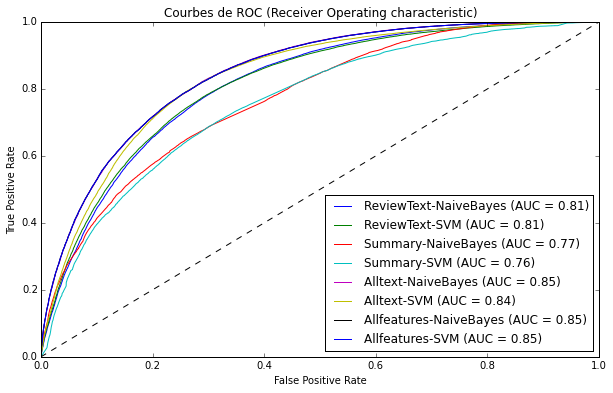

In [69]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)
from sklearn.metrics import roc_curve, auc
probas = [probas_bin_NaiveBayes_reviewText,probas_bin_SVM_reviewText,
         probas_bin_NaiveBayes_summary, probas_bin_SVM_summary,
         probas_bin_NaiveBayes_alltext, probas_bin_SVM_alltext,
         probas_bin_NaiveBayes_allfeatures, probas_bin_SVM_allfeatures]
labels=["ReviewText-NaiveBayes","ReviewText-SVM","Summary-NaiveBayes","Summary-SVM",
        "Alltext-NaiveBayes","Alltext-SVM","Allfeatures-NaiveBayes","Allfeatures-SVM"]
fpr= [None] * len(probas)
tpr=[None] * len(probas)
thresholds=[None] * len(probas)
roc_auc=[None] * len(probas)
for i in range(len(probas)):    
    fpr[i], tpr[i], thresholds[i] = sklearn.metrics.roc_curve(y_test_bin.ravel().astype(float), probas[i], pos_label=1.0)
    roc_auc[i]=auc(fpr[i],tpr[i])
    plt.plot(fpr[i], tpr[i], label=labels[i]+" (AUC = %0.2f)" % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes de ROC (Receiver Operating characteristic)')
plt.legend(loc="lower right")

In [70]:
np.mean(y_test_bin.ravel().astype(float))

0.62022051840818893

On voit que l'apport des features supplémentaires n'importe qu'un petit gain d'AUC au classifieur SVM. Les modèles Naive Bayes sont toujours bien supérieurs en termes d'AUC aux modèles SVM.

## Optimisation des hyper-paramètres pour la classification binaire

Nous allons nous concentrer ici sur l'optimisation des hyperparamètres de chacun des classifieurs sur l'intégralité des features.

### 1. Optimisation du classifieur Naive Bayes

In [156]:
from sklearn import grid_search
parameters_NB = {'alpha':list(np.linspace(0.001,10,50))}
clf1=grid_search.GridSearchCV(MultinomialNB(), parameters_NB)
clf1.fit(X_train_allfeatures, y_train_bin)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.20506122448979594, 0.40912244897959188, 0.61318367346938785, 0.81724489795918376, 1.0213061224489797, 1.2253673469387756, 1.4294285714285715, 1.6334897959183674, 1.8375510204081633, 2.0416122448979594, 2.2456734693877554, 2.4497346938775513, 2.6537959183673472, 2.85785...6938775510213, 9.1837551020408164, 9.3878163265306132, 9.5918775510204082, 9.795938775510205, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [157]:
best_parameters, score, _ = max(clf1.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters_NB.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

alpha: 0.001


In [158]:
score

0.80752173117519033

In [159]:
predicted_bin_NaiveBayes_optim_allfeatures = clf1.predict(X_test_allfeatures)

### 2. Optimisation du classifieur SVM

In [151]:
parameters_SVM = {'alpha':list(np.linspace(0.000001,0.001,50)),
                  'loss':["modified_huber","log"],
                  'penalty': ["l2", "l1","elasticnet"],
                 }
clf2=grid_search.GridSearchCV(SGDClassifier(), parameters_SVM)
clf2.fit(X_train_allfeatures, y_train_bin)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [9.9999999999999995e-07, 2.1387755102040818e-05, 4.1775510204081632e-05, 6.2163265306122456e-05, 8.2551020408163267e-05, 0.00010293877551020408, 0.00012332653061224492, 0.00014371428571428573, 0.00016410204081632654, 0.00018448979591836735, 0.00020487755102040816, 0.000225265306...97961224489795926, 0.001], 'penalty': ['l2', 'l1', 'elasticnet'], 'loss': ['modified_huber', 'log']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [153]:
best_parameters, score, _ = max(clf2.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters_SVM.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

alpha: 8.2551020408163267e-05
loss: 'modified_huber'
penalty: 'elasticnet'


In [152]:
predicted_bin_SVM_optim_allfeatures = clf2.predict(X_test_allfeatures)

### Comparaison de performance entre classifieurs optimisés et non optimisés

In [160]:
index_clf=["NaiveBayes-Basic","NaiveBayes-Optimized","SVM-Basic","SVM-Optimized"]
predicted_clf=[predicted_bin_NaiveBayes_allfeatures, predicted_bin_NaiveBayes_optim_allfeatures,
               predicted_bin_SVM_allfeatures, predicted_bin_SVM_optim_allfeatures]
def percent_round1(x):
    return(str((x*100).round(1))+"%")
Accuracy_clf=[percent_round1(np.mean(x==y_test_bin)) for x in predicted_clf]
Report_clf=[sklearn.metrics.precision_recall_fscore_support(y_test_bin, x) for x in predicted_clf]
Precision_clf=[percent_round1(x[0][1]) for x in Report_clf]
Recall_clf=[percent_round1(x[1][1]) for x in Report_clf]
f1score_clf=[percent_round1(x[2][1]) for x in Report_clf]

dic_clf = {'Accuracy' : pd.Series(Accuracy_clf, index=index_clf),
     'Precision' : pd.Series(Precision_clf, index=index_clf),
     'Recall' : pd.Series(Recall_clf, index=index_clf),
     'f1-score': pd.Series(f1score_clf, index=index_clf),
    }
df_clf=pd.DataFrame(dic_clf)
df_clf

,Accuracy,Precision,Recall,f1-score
NaiveBayes-Basic,80.6%,80.4%,88.2%,84.1%
NaiveBayes-Optimized,80.6%,80.4%,88.2%,84.1%
SVM-Basic,80.6%,80.4%,88.2%,84.1%
SVM-Optimized,83.9%,83.8%,89.6%,86.6%


On voit que l'optimisation est sensible pour le classifieur SVM, qui dépasse maintenant le classifieur Naive Bayes. Cependant, le temps de calcul a été beaucoup plus long pour SVM que pour Naive Bayes.

## Analyse de la performance en fonction du nombre de mots

In [79]:
def createBins(x):
    if x["countWordsReview"] < 17:
        return(17)
    elif x["countWordsReview"] < 30:
        return(30)
    elif x["countWordsReview"] < 60:
        return(60)
    elif x["countWordsReview"] < 100:
        return(100)
    elif x["countWordsReview"] < 200:
        return(200)
    else:
        return(300)

In [80]:
perf_number_words = pd.merge(pd.DataFrame(y_test_bin), pd.DataFrame(df_test["countWordsReview"]), left_index=True, right_index=True)

In [81]:
perf_number_words = perf_number_words.reset_index()
perf_number_words = perf_number_words.drop('index', axis = 1)

In [82]:
x_predicted_bin = pd.DataFrame(predicted_bin_NaiveBayes_optim_allfeatures)

In [83]:
perf_number_words["predicted"] = x_predicted_bin

In [84]:
perf_number_words["bin"] = perf_number_words.apply(createBins, axis = 1)

In [85]:
def calaccuracy(x):
    return(1-abs(int(x["overall"])-int(x["predicted"])))

In [86]:
perf_number_words["accuracy"] = perf_number_words.apply(calaccuracy, axis = 1)

In [87]:
def pourcentage(x):
    return(str((x["accuracy"]*100).round(1))+"%")

In [89]:
result = perf_number_words.groupby(["bin"], as_index=False).agg(np.mean)
result["accuracy"] = result.apply(pourcentage, axis = 1)
result

,bin,countWordsReview,accuracy
0,17,8.667513,88.4%
1,30,23.410642,80.6%
2,60,42.368137,79.0%
3,100,76.923658,78.3%
4,200,138.866076,76.8%
5,300,366.937513,73.2%


## Analyse des mots qui jouent un rôle prépondérant dans la prédiction de l'algorithme Naive Bayes

In [90]:
corpus_train_reviewText=list(df_train["reviewText"].astype(str))
X_train_tfidf_reviewText = tfidf_vect_stopword.fit_transform(corpus_train_reviewText)

In [91]:
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train.astype('category'))

In [94]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = tfidf_vect_stopword.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1,coef_2, fn_2))

In [95]:
show_most_informative_features(X_train_tfidf_reviewText, clf, n = 20)

	-11.8523	atmospheric    		-5.2188	one            
	-11.8523	bluesy         		-5.2297	product        
	-11.8523	choruses       		-5.3016	work           
	-11.8523	collaboration  		-5.3333	would          
	-11.8523	concerti       		-5.4444	get            
	-11.8523	emotionally    		-5.4648	money          
	-11.8523	excellence     		-5.4687	buy            
	-11.8523	haunting       		-5.5691	even           
	-11.8523	joseph         		-5.5816	guitar         
	-11.8523	playful        		-5.6445	return         
	-11.8523	poem           		-5.6828	back           
	-11.8523	stravinsky     		-5.7193	like           
	-11.8523	strengths      		-5.7322	bought         
	-11.8523	subdued        		-5.7453	waste          
	-11.8523	superbly       		-5.7514	item           
	-11.8324	expressive     		-5.7939	time           
	-11.8303	strauss        		-5.8250	got            
	-11.8282	1963           		-5.8309	sound          
	-11.8234	arguably       		-5.8320	amazon         
	-11.8228	waltz          		-5.8

## Utilisation du modèle sur des données de reviews de la catégorie "Baby"

On applique le modèle qui a fait l'apprentissage sur les reviews des musical instruments sur les reviews des produits de la catégorie "Baby".

In [97]:
data1=[]
filepath="reviews_Baby.json"
with open(filepath) as f:
    for line in f:
        data1.append(json.loads(line))
df_baby=pd.DataFrame(data1)

In [98]:
y_baby = df_baby["overall"]
df_baby = df_baby.drop("overall",axis=1,inplace=False)
df_baby["countWordsReview"] = df_baby["reviewText"].astype(str).apply(countWords)
df_baby["countWordsSummary"] = df_baby["summary"].astype(str).apply(countWords)

In [106]:
corpus_baby_reviewText=list(df_baby["reviewText"].astype(str))
corpus_baby_summary=list(df_baby["summary"].astype(str))
X_baby_tfidf_reviewText = tfidf_vect_stopword.transform(corpus_baby_reviewText)
X_baby_tfidf_reviewText.shape

(915448, 6419)

In [108]:
X_baby_tfidf_summary = tfidf_vect_stopword.transform(corpus_baby_summary)
df_baby["Weekday"] = df_baby["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_baby["Month"] = df_baby["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
X_baby_countWords=normalize(df_baby[["countWordsReview","countWordsSummary"]].astype(float),axis=0)
dic_baby_weekdays = pd.DataFrame(df_baby["Weekday"]).to_dict('records')
X_baby_weekdays = dic_vec.fit_transform(dic_baby_weekdays)
dic_baby_months = pd.DataFrame(df_baby["Month"]).to_dict('records')
X_baby_months = dic_vec.fit_transform(dic_baby_months)

In [109]:
X_baby_alltext=hstack([X_baby_tfidf_reviewText, X_baby_tfidf_summary])
X_baby_allfeatures = hstack([X_baby_alltext,X_baby_countWords, X_baby_weekdays, X_baby_months])

In [110]:
X_baby_allfeatures.shape

(915448, 7219)

In [111]:
predicted_bin_SVM_optim_baby = clf2.predict(X_baby_allfeatures)

In [112]:
y_baby_bin=y_baby.apply(bin_transformation).astype("category")

In [113]:
(np.mean(predicted_bin_SVM_optim_baby == y_baby_bin)*100).round(1)

81.799999999999997

L'apprentissage a été fait sur des reviews de produits d'une autre catégorie, mais les résultats obtenus par ce modèle sont aussi bon que sur l'échantillon test des reviews de produits de la catégorie "Musical Instruments".